# U-Net

Define unet model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np

device = torch.device('cuda')

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear: # no.
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

 
# else, obstacle, path.
colorMap = [[254, 235, 206], [58, 64, 175], [50, 39, 24]] # BGR.


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear 
        
        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        self.down3 = (Down(128, 256))
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor))
        self.up1 = (Up(512, 256 // factor, bilinear))
        self.up2 = (Up(256, 128 // factor, bilinear))
        self.up3 = (Up(128, 64 // factor, bilinear))
        self.up4 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, n_classes))


    def forward(self, x): 
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits

    def use_checkpointing(self): 
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

 
 
    def predict(self, image):   
        '''
            image: (64, 64, 3), BGR, numpy array. 
        '''             

        

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (64, 64, 3), RGB.
        image = np.transpose(image, (2, 0, 1)) # (3, 64, 64), RGB.

        
        
        # image = torch.from_numpy(image).to(device=device, dtype=torch.float32,
        #                          memory_format=torch.channels_last).unsqueeze(0) # (1, 3, 64, 64), RGB.

         
        image = image / 255.0

        image = torch.as_tensor(image).float().contiguous()
#         image = image.to(device=device, dtype=torch.float32,  
#                                 memory_format=torch.channels_last).unsqueeze(0) # (1, 3, 64, 64), RGB.  
        
        image = image.to(device=device).unsqueeze(0) # (1, 3, 64, 64), RGB.  
        
        
        
        mask_pred = self(image).argmax(dim=1)[0] # (64, 64).
        
        # image = np.transpose(image.detach().cpu().numpy()[0], (1,2,0))            
        mask_pred = mask_pred.detach().cpu().numpy() # (64, 64).
            
        mask3 = np.zeros((64, 64, 3)).astype(np.uint8)
        for clsId in range(self.n_classes):
            mask3[mask_pred==clsId] = np.array(colorMap[clsId])

        mask3 = np.transpose(mask3, (2, 0, 1)) # (3, 64, 64), BGR.
                    
        return mask3 
    
    

    def load(self, dir_name, name):

        path = os.path.join(dir_name, name)

        state_dict = torch.load(path)
      
        del state_dict['mask_values']

        self.load_state_dict(state_dict) 
    
        print(f'loaded unet ckpt: {path}')



In [3]:

unet = UNet(n_channels=3, n_classes=3, bilinear=False)
unet.load('ckpt', 'unet.pth')
unet.eval()
unet.to(device=device)
print()

loaded unet ckpt: ckpt/unet.pth



In [3]:
# import traitlets
# import ipywidgets.widgets as widgets
# from IPython.display import display
# from jetbot import Camera, bgr8_to_jpeg
# import os
# import time
# from PIL import Image
# from matplotlib import pyplot as plt

# import time



# # Create data folder.
# image_folder = "unet_output/"
# if not os.path.exists(image_folder):
#     os.makedirs(image_folder)



# def preprocess(camera_value): 

#     global unet
    
#     img = camera_value # (h, w, c), BGR. 
    
    
    
#     start_time = time.time() 
#     img = img[:, 210:-210, :]
#     print("crop: %s sec" % (time.time() - start_time))
    
#     assert img.shape == (540, 540, 3)
    
#     img = Image.fromarray(img)
    
#     start_time = time.time() 
#     img = img.resize((64, 64), Image.BILINEAR)
#     print("resize(): %s sec" % (time.time() - start_time))
    
#     img = np.array(img) # (64, 64, 3), BGR.  
    
# #     print(f'camera_value.shape: {camera_value.shape}, img.shape: {img.shape}')
  
#     start_time = time.time() 
#     mask = unet.predict(img) # (3, 64, 64), BGR.
#     print("predict(): %s sec" % (time.time() - start_time))    
    
    
# #     print(f'[b] mask.shape: {mask.shape}')
    
#     mask = cv2.cvtColor(np.transpose(mask, (1, 2, 0)), cv2.COLOR_BGR2RGB) # (64, 64, 3), RGB.
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # (64, 64, 3), RGB.  

#     return img, mask



# # Save image when camera update the vlaue.
# def update(change):

#     global frame_id, image_folder
#     fname = str(frame_id).zfill(4) + ".jpg"

# #     print('[update()]')
#     img, mask = preprocess(change['new']) 
    
# #     print(f'img.shape: {img.shape}, mask.shape: {mask.shape}')
    
#     plt.subplot(121) 
#     plt.imshow(img) 
#     plt.axis('off') 
#     plt.title("input image") 

#     plt.subplot(122) 
#     plt.imshow(mask)
#     plt.axis('off') 
#     plt.title("mask") 

#     plt.savefig(image_folder + fname) 

#     print("\rsave data " + fname, end="")
#     frame_id += 1
    
#     print('----------------------')
#     time.sleep(0.05)

 

# # Activate the camera.
# camera = Camera.instance(width=960, height=540, capture_width=1280, capture_height=720)
# # image = widgets.Image(format='jpeg', width=480, height=270)  # this width and height doesn't necessarily have to match the camera
# # camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
 
# # Start collect & segment data.
# frame_id = 0
# camera.observe(update, names='value')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6q9yr4dv because the default path (/home/jetbot/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


crop: 1.7404556274414062e-05 sec
resize(): 0.005474090576171875 sec
predict(): 7.331961631774902 sec
save data 0000.jpg----------------------
crop: 1.5974044799804688e-05 sec
resize(): 0.0056302547454833984 sec
predict(): 0.05717825889587402 sec


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


save data 0001.jpg----------------------
crop: 1.9073486328125e-05 sec
resize(): 0.005331516265869141 sec
predict(): 0.04454541206359863 sec
save data 0002.jpg----------------------
crop: 1.8358230590820312e-05 sec
resize(): 0.005438327789306641 sec
predict(): 0.03585314750671387 sec
save data 0003.jpg----------------------
crop: 1.8596649169921875e-05 sec
resize(): 0.00532984733581543 sec
predict(): 0.03470444679260254 sec
save data 0004.jpg----------------------
crop: 1.4781951904296875e-05 sec
resize(): 0.006645917892456055 sec
predict(): 0.03781533241271973 sec
save data 0005.jpg----------------------
crop: 1.811981201171875e-05 sec
resize(): 0.0052988529205322266 sec
predict(): 0.033802032470703125 sec
save data 0006.jpg----------------------
crop: 1.8596649169921875e-05 sec
resize(): 0.0054590702056884766 sec
predict(): 0.0408940315246582 sec
save data 0007.jpg----------------------
crop: 1.6450881958007812e-05 sec
resize(): 0.006649971008300781 sec
predict(): 0.05198264122009277

Stop camera

save data 0079.jpg

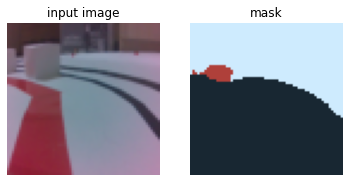

In [4]:
# camera.unobserve(update, names='value')
# time.sleep(0.1)
# # camera_link.unlink()
# camera.stop()



# Agent

In [4]:
import torch
import torch.nn.functional as F

import numpy as np
import os 
  
import cv2
   
import torch.nn as nn 
from torch.distributions import Normal

  
from collections import OrderedDict



action_low = np.array([0.0, 0.0])
action_high = np.array([0.5, 0.5])

action_dim = 2
obs_shape = (64, 64, 3)
 
DEVICE = "cpu"
 
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6


class AttrDict(dict):
    def __getattr__(self, key):
        if key in self:
            value = self[key]
            if isinstance(value, dict):
                return AttrDict(value)
            return value
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{key}'")

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        if key in self:
            del self[key]
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{key}'")


            
sac_args = AttrDict({      
    'hidden_size': 512, 
    'input_dim': 32    
})



def action_rescale(action):
    action = action_low + (action + 1.0) * 0.5 * (action_high - action_low)
    return np.clip(action, action_low, action_high)
 




# Initialize Policy weights
def weights_init_(m):
 
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

  



class ConvBlock(nn.Module):
   
    def __init__(self, in_channels: int, 
                        out_channels: int,
                        kernel_size: int, 
                        stride: int = 2, 
                        padding: int = 1, 
                        slope: float = 0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(negative_slope=slope)
    
    def forward(self, x):
  
        return self.relu(self.bn(self.conv(x)))

 

class Encoder(nn.Module):
 
    def __init__(self, z_dim: int = 32):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(3, 32, 4, stride=2, padding=1)),
            ("relu1", nn.LeakyReLU(0.2)), #32x32x32
            ("block1", ConvBlock(32, 64, 4, stride=2, padding=1, slope=0.2)), # 64x16x16
            ("block2", ConvBlock(64, 128, 4, stride=2, padding=1, slope=0.2)), # 128x8x8
            ("block3", ConvBlock(128, 256, 4, stride=2, padding=1, slope=0.2)), # 256x4x4
        ]))

        self.fc = nn.Linear(4096, z_dim)
      
 
    def forward(self, x):
 
        x = self.encoder(x)
        x = x.view(-1, 4096)
        return self.fc(x) 


class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        
        self.enc = Encoder(num_inputs)
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim) # 32, 512.
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # 512, 512.

        self.mean_linear = nn.Linear(hidden_dim, num_actions) # 512, 2.
        self.log_std_linear = nn.Linear(hidden_dim, num_actions) # 512, 2.

        self.apply(weights_init_)


    def forward(self, state, vel):
        
        # state = self.enc(state)
        x = torch.cat([self.enc(state), vel], 1)        

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std


    def sample(self, state, vel):
        mean, log_std = self.forward(state, vel)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t)

        # Enforcing Action Bound
        log_prob -= torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)

        return action, log_prob, torch.tanh(mean) # (b, act_dim), (b, 1), (b, act_dim). 

 
 
class SAC(object):
 
    def __init__(self):
           
        self.policy = GaussianPolicy(sac_args.input_dim, action_dim, sac_args.hidden_size).to(DEVICE)
         
      
    def select_action(self, obs, vel):
        '''
            obs: BGR, (3, 64, 64).
        '''

        obs = torch.FloatTensor(obs).to(DEVICE).unsqueeze(0) # (1, 3, 64, 64).
        vel = torch.FloatTensor(vel).to(DEVICE).unsqueeze(0) # (1, 2).

        assert tuple(obs.shape) == (1, 3, 64, 64)

        action, _, _ = self.policy.sample(obs, vel)

        action = action.detach().cpu().numpy() # (1, 2).
        assert  action.shape == (1, action_dim)


        return action_rescale(action[0]) # (2,).


 

    def load(self, dir_name, name):

        path = os.path.join(dir_name, name)

#         checkpoint = torch.load(path)
#         self.policy.load_state_dict(checkpoint['policy']) 

        state_dict = torch.load(path)
        self.policy.load_state_dict(state_dict) 
        self.policy.eval()
        self.policy.to(DEVICE)
    
    
        print(f'loaded ckpt: {path}')



In [5]:
agent = SAC()
agent.load('ckpt', 'sac.pth')

loaded ckpt: ckpt/sac.pth


# Camera

In [1]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg
 
camera = Camera.instance(width=960, height=540, capture_width=1280, capture_height=720)
 
 

# Robot

In [6]:
from jetbot import Robot


robot = Robot() 
robot.set_motors(0, 0)

# Run

In [44]:
import cv2
import numpy as np
import torch
import torchvision

import time

from PIL import Image
 

 
cur_vel = np.array([0.0, 0.0])


 
def preprocess(camera_value): 
    '''
        Semantic segmentation using U-Net.
    '''
    global unet
    
    img = camera_value # (h, w, c), BGR. 

    # TODO: distorsion calibration.
    img = img[:, 210:-210, :]

    img = Image.fromarray(img)
    img = img.resize((64, 64), Image.BILINEAR)
    img = np.array(img) # (64, 64, 3), BGR.  
  
    mask = unet.predict(img) # (3, 64, 64), BGR.

    return mask

  
  
def update(change):

    global robot, agent, cur_vel
    
    cur_obs = preprocess(change['new']) # (3, 64, 64), BGR.
    
    # cur_obs: BGR, (3, 64, 64).
    cur_vel = agent.select_action(cur_obs, cur_vel)

    div = 6.0  
    robot.set_motors(cur_vel[0]/div, cur_vel[1]/div)
    
#     print(f'\rspeed_l: {round(cur_vel[0], 3)}, speed_r: {round(cur_vel[1], 3)}')
    time.sleep(0.001) # If performnace is not good, try tuning this delay.
        
 
    
    
update({'new': camera.value})  # we call the function once to initialize

camera.observe(update, names='value')  # this attaches the 'update' function to the 'value' traitlet of our camera


In [45]:
camera.unobserve(update, names='value')
time.sleep(0.1)  # add a small sleep to make sure frames have finished processing

robot.left(speed=0)
robot.right(speed=0)

# test

In [6]:
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
import os
import time
 
# image_folder = "Images/"
# if not os.path.exists(image_folder):
#     os.makedirs(image_folder)
 
def update(change):    
    
    print(f"change['new'].shape: {change['new'].shape}")
    time.sleep(0.5)
 
camera = Camera.instance(width=960, height=540, capture_width=1280, capture_height=720)
# image = widgets.Image(format='jpeg', width=480, height=270)  # this width and height doesn't necessarily have to match the camera
# camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
# display(image)

 

In [7]:

camera.observe(update, names='value')


In [5]:
camera.unobserve(update, names='value')
time.sleep(0.1)
camera.stop()